Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.3) 미래에 볼 영화의 평점 예측하기

### 바로가기

- [<Step1. 탐색> : MovieLens 데이터 살펴보기](#<Step1.-탐색>-:-MovieLens-데이터-살펴보기)
    - [MovieLens 데이터셋의 기본 정보]
- [<Step2. 분석> : 탐색적 데이터 분석](#<Step2.-분석>-:-탐색적-데이터-분석)
    - [분석할 영화의 정보 탐색하기]
    - [장르의 속성 탐색]
    - [분석할 유저의 정보 탐색하기]
    - [평점 데이터의 정보 탐색하기]
    - [user-movie 형태의 테이블로 살펴보기]
- [<Step3. 예측> : 수학적 기법을 활용한 평점 예측](#<Step3.-예측>-:-수학적-기법을-활용한-평점-예측)
    - [SVD를 활용한 빈칸 채우기]
    - [아직 평가하지 않은 영화의 점수 예측하기]
- [<Step4. 평가> : 예측 모델 평가하기](#<Step4.-평가>-:-예측-모델-평가하기)
    - [예측 모델의 평가 방법]
    - [실제 평점과의 비교 시각화]
    - [한걸음 더 : 20대가 좋아할만한 영화를 예측해보자]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : MovieLens 데이터 살펴보기

### [MovieLens 데이터셋의 기본 정보]

In [2]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [3]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


-----

# <Step2. 분석> : 탐색적 데이터 분석

### [분석할 영화의 정보 탐색하기]

In [7]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

-----

### `[미니 퀴즈 - 3.3]`
- `영화 데이터에 대한 탐색적 데이터 분석을 더 실행해 봅시다. 영화의 연대별 갯수를 탐색해 보세요.`

In [8]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


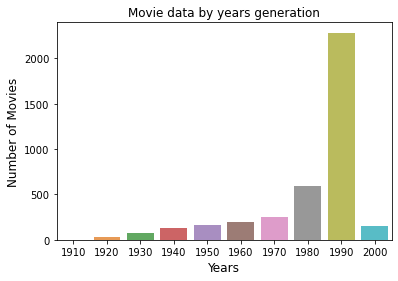

In [9]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

-----

### [장르의 속성 탐색] 

In [10]:
# 가장 많이 사용된 장르의 조합을 출력합니다. (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

-----

In [11]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


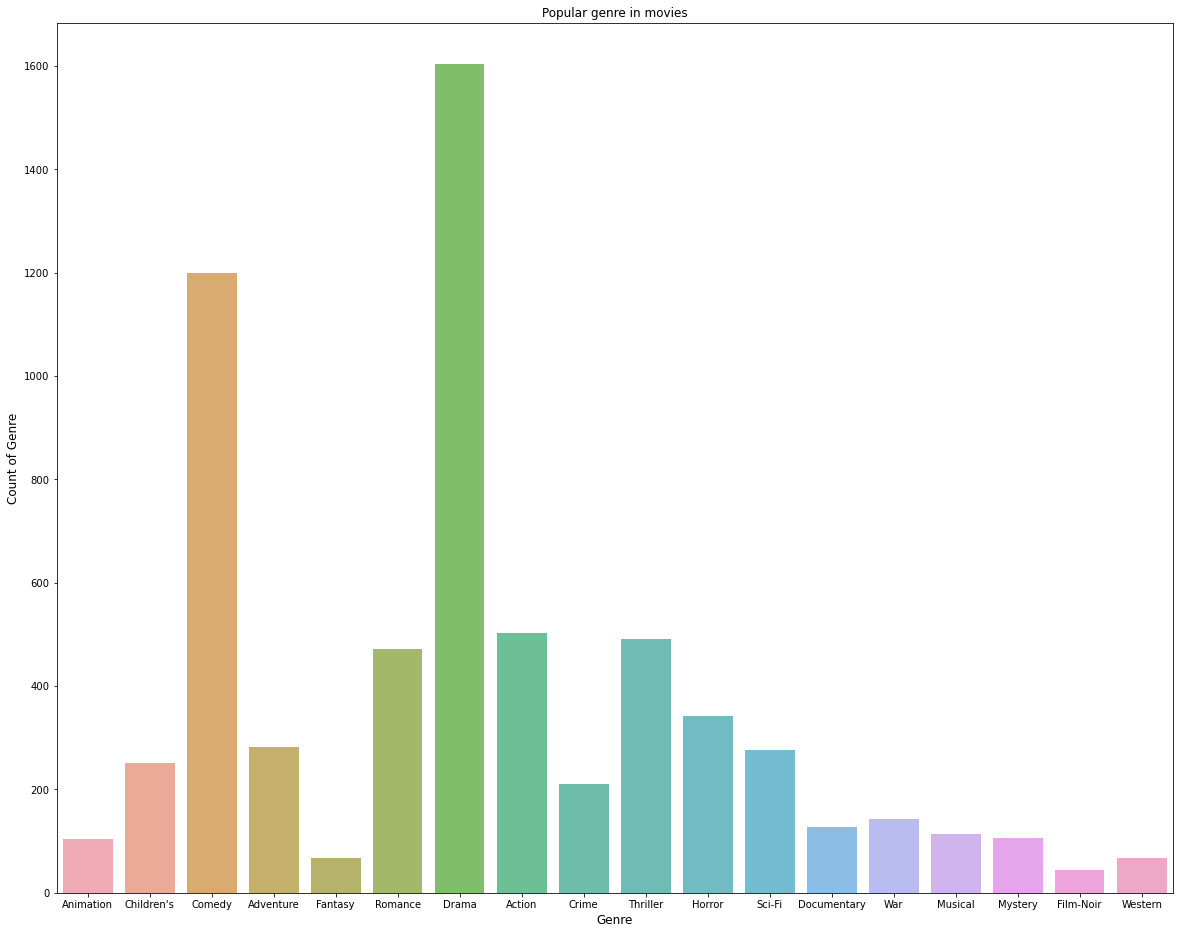

In [12]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

### [분석할 유저의 정보 탐색하기]

In [13]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


-----

### `[미니 퀴즈 - 3.4]`
- `유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다. 아래의 질문들에 답해보세요.` 
    - 유저의 성별 탐색
    - 유저의 연령대 탐색

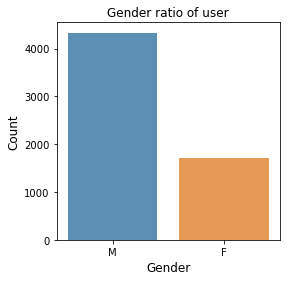

In [14]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [15]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [16]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

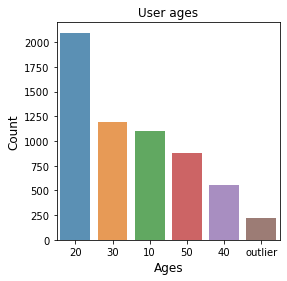

In [17]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

-----

### [평점 데이터의 정보 탐색하기]

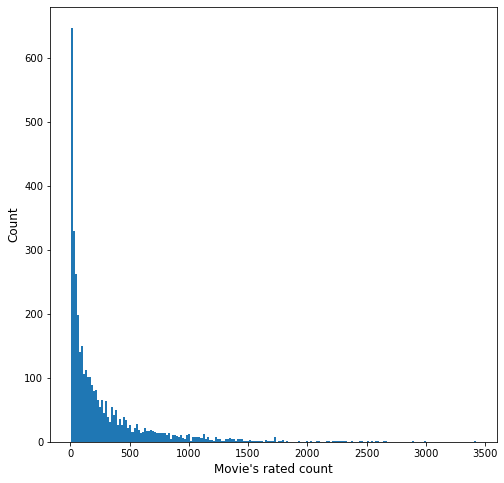

In [18]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [19]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


-----

In [20]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [21]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

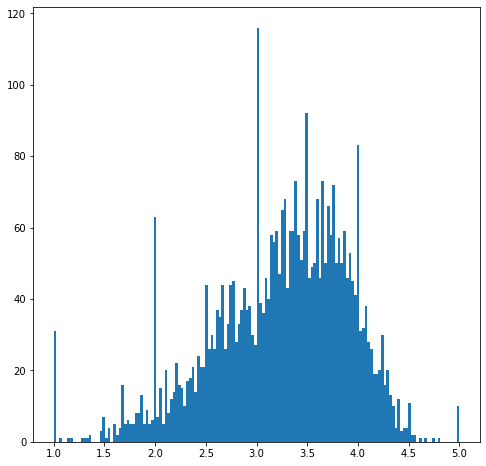

In [22]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

-----

In [23]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


-----

### `[미니 퀴즈 - 3.5]`
- `동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석해 보세요.` 
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [24]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [25]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

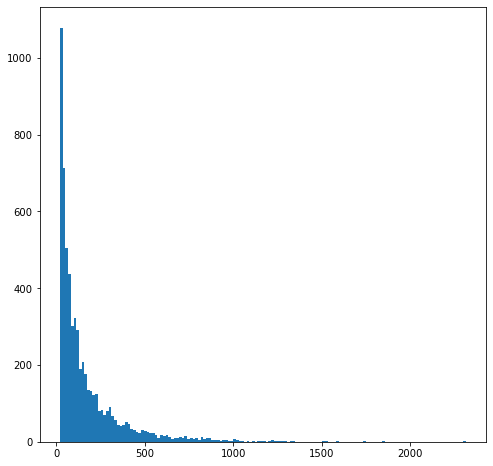

In [26]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

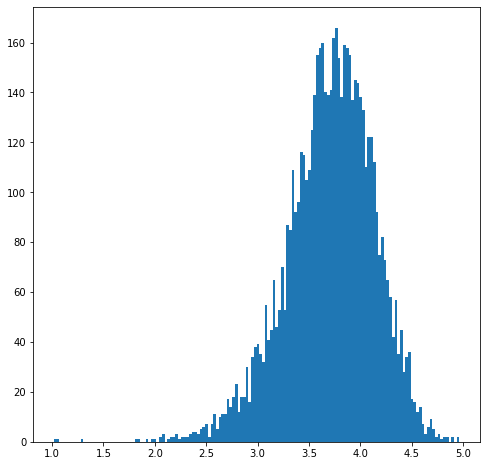

In [27]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

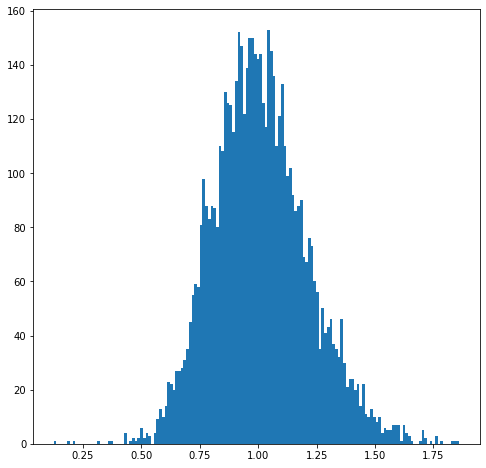

In [28]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

-----

### [user-movie 형태의 테이블로 살펴보기]

In [29]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [30]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

-----

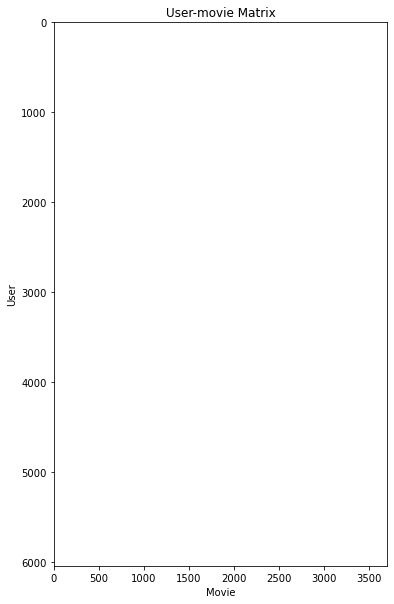

In [31]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

-----

# <Step3. 예측> : 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) `pip install surprise`

-----

##### 빈칸을 포함한 user-item 행렬 생성

In [32]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [33]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [34]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

-----

##### SVD를 이용한 빈칸 채우기 학습

In [35]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [36]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [37]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.6176720634842283
Item id 3 | predicted rating : 3.8072708960766337


In [38]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.5183633983905285
Item id 2 | real rating : 4.0 | predicted rating : 3.8114382515502094
Item id 3 | real rating : 4.0 | predicted rating : 3.6812621198440865
Item id 1 | real rating : 2.0 | predicted rating : 3.525603189624819
Item id 2 | real rating : 5.0 | predicted rating : 3.826767028758042
Item id 3 | real rating : 4.0 | predicted rating : 3.795815352517194
Item id 2 | real rating : 5.0 | predicted rating : 3.9031935538101723


-----

### [아직 평가하지 않은 영화의 점수 예측하기]

##### MovieLens 데이터에 SVD 적용하기

In [39]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 56.03 seconds


-----

##### 영화의 점수를 예측할 타겟 유저 선정

In [40]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [41]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


-----

##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [42]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [43]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [44]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [45]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(111, 5),
 (116, 5),
 (326, 5),
 (527, 5),
 (602, 5),
 (608, 5),
 (615, 5),
 (669, 5),
 (858, 5),
 (912, 5)]

In [46]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [47]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Taxi Driver (1976) : 5
Anne Frank Remembered (1995) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
Godfather, The (1972) : 5
Casablanca (1942) : 5


In [48]:
# 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


-----

# <Step4. 평가> : 예측 모델 평가하기

### [예측 모델의 평가 방법]

##### RMSE 계산하기

In [49]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 62.41 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8630


0.8629744853592757

-----

### `[미니 퀴즈 - 3.6]`
- `SVD 예제에서 하이퍼 파라미터를 바꿔가며 RMSE를 출력해 보세요.` 
    - RMSE를 이용해 적당한 하이퍼 파라미터 n_factors를 찾아봅시다.
    - 하이퍼 파라미터 n_factors 설정 변화에 따른 RMSE 그래프를 출력해 보세요.

##### 하이퍼 파라미터 튜닝 예시

In [50]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 48.02 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8850
------------------------------------
training time of model: 51.68 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8752
------------------------------------
training time of model: 51.24 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8684
------------------------------------
training time of model: 53.13 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8663
------------------------------------
training time of model: 57.26 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8616
------------------------------------
training time of model: 62.25 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8621
------------------------------------
training time of model: 62.63 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8598
------------------------------------
training time of model: 63.21 seconds
RMSE of test data

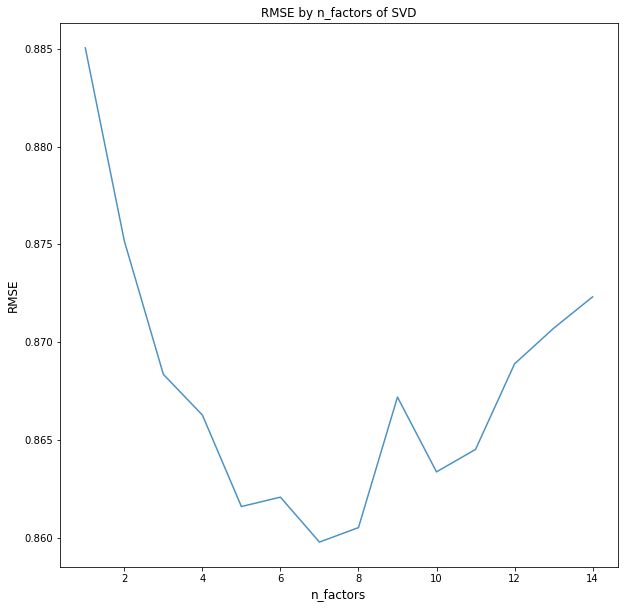

In [51]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

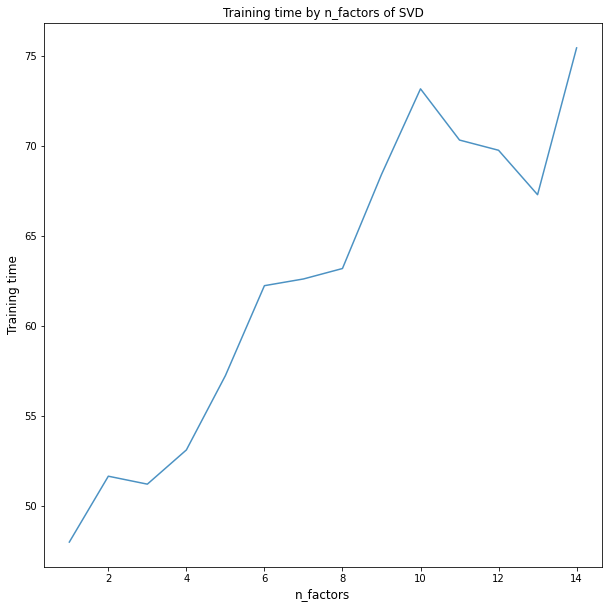

In [52]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

-----

### [실제 평점과의 비교 시각화]

##### 평점 예측 단계

In [53]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [54]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [55]:
target_user_movie_predict_dict

{260: 4.669811760232215,
 480: 3.5499520398324664,
 1036: 4.067559263810663,
 1097: 4.422685165390757,
 1196: 4.386054549328846,
 1198: 4.730425980231516,
 1201: 4.59109135474278,
 1210: 3.919841339066396,
 1214: 4.311090900869608,
 1240: 4.126578825072968,
 1387: 4.430187368191141,
 1954: 4.393215562513734,
 2028: 4.698629475204382,
 2366: 4.169690088504024,
 2692: 4.3092535728934065,
 2947: 4.480990921258208,
 2951: 4.409884720934135,
 3418: 4.100185144693687,
 3468: 4.973090802820813,
 3527: 3.117144386132302,
 3702: 3.81550109821816}

In [56]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.67
movie 2 : Jurassic Park (1993) - 4 / 3.55
movie 3 : Die Hard (1988) - 4 / 4.07
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.42
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 4.39
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.73
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.59
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.92
movie 9 : Alien (1979) - 4 / 4.31
movie 10 : Terminator, The (1984) - 5 / 4.13
movie 11 : Jaws (1975) - 5 / 4.43
movie 12 : Rocky (1976) - 5 / 4.39
movie 13 : Saving Private Ryan (1998) - 5 / 4.7
movie 14 : King Kong (1933) - 4 / 4.17
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.31
movie 16 : Goldfinger (1964) - 5 / 4.48
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.41
movie 18 : Thelma & Louise (1991) - 4 / 4.1
movie 19 : Hustler, The (1961) - 5 / 4.97
movie 20 : Predator (1987) - 1 / 3.12
movie 21 : Mad Max (1979) - 4 / 3.82


-----

##### 결과의 시각화

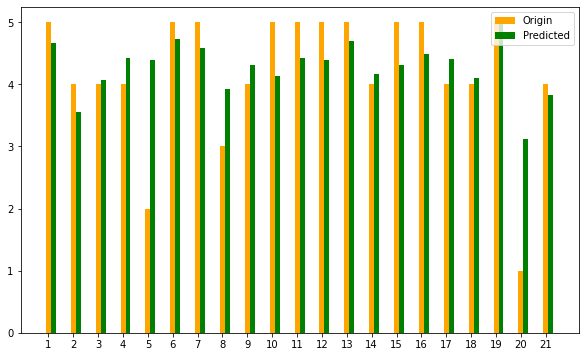

In [57]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

-----

### `한걸음 더 나아가기`
- `20대가 좋아할만한 영화 예측하기.` 

##### 20대 유저 리스트 선정

In [58]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

- 평가하지 않은 user-movie rating들에 대한 예측값을 통해, 20대가 좋아할 것 같은 영화 리스트 선정

-----

##### (참고) 아래의 코드는 약 10분 이상이 소요되는 과정입니다.

In [59]:
# 평가하지 않은 user-movie rating들에 대한 예측값을 계산합니다.
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별합니다.
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# 영화마다 20대 유저의 rating 평균값을 계산합니다.
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id를 추출합니다.
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 536.19 seconds


In [60]:
# 선정된 리스트를 출력합니다.
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.614211592128805
title: Usual Suspects, The (1995) | rating: 4.507429968125585
title: Shawshank Redemption, The (1994) | rating: 4.501622776963358
title: Lamerica (1994) | rating: 4.4710823068785706
title: Schindler's List (1993) | rating: 4.421405520686119
title: Gate of Heavenly Peace, The (1995) | rating: 4.388158707460173
title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) | rating: 4.3848875725526595
title: Rear Window (1954) | rating: 4.376849170003736
title: Close Shave, A (1995) | rating: 4.359447901206616
title: Raiders of the Lost Ark (1981) | rating: 4.3553438584979185
